In [7]:
import sys
sys.path.append('../')

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotting
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import detrend
%matplotlib inline

In [9]:
from load_dataset import Dataset

In [10]:
dataset = Dataset('../data/dataset/')

In [11]:
# возьмем временной ряд, характеризующий продажи алкоголя по месяцам
ts = dataset["alcohol_sales.csv"]

In [12]:
ts, ts_test = ts[:250], ts[250:]

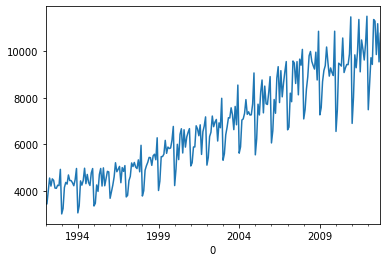

In [13]:
ts.plot()

In [14]:
# как можно заметить, у него есть окололинейный тренд, гетероскедастичность, сезонный период равен 12 (месяцам)

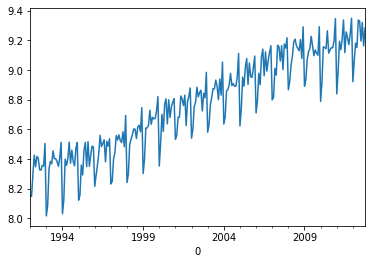

In [15]:
# сначала уберем гетероскедастичность простым логарифмированием
ts_log = np.log(ts)
ts_log.plot()

In [16]:
# Теперь подберем порядки дифференцирования d, D
# d малое подбирается таким образом, что d раз продифференцировав ряд, мы добьемся стационарности
# D большое обычно подбирается так, что если d малое не дало стацинарности, мы можем D раз сезонно придифференцировать
# ряд, пока он не станет стационарным.

In [17]:
# для начала просто продифференцируем один раз

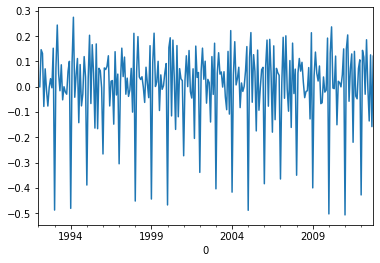

In [18]:
ts_log.diff().plot()

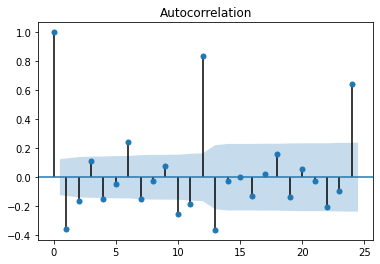

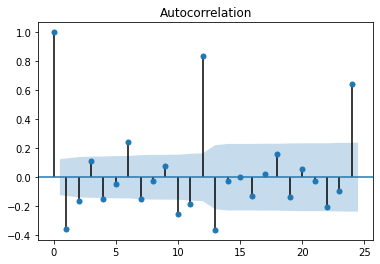

In [19]:
# в данном случае ряд сохраняет сезонность
plot_acf(ts_log.diff().dropna())

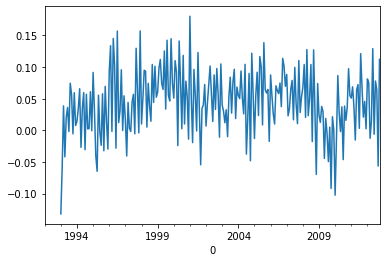

In [20]:
# попробуем применить сезонное дифференцирование 
ts_log.diff(12).plot()

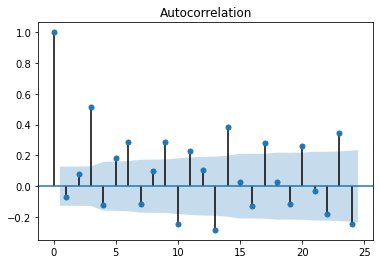

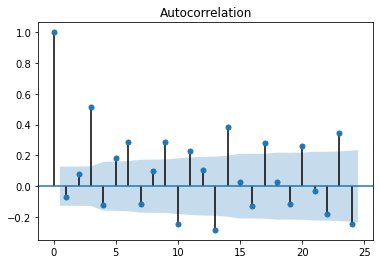

In [21]:
plot_acf(ts_log.diff(12).dropna())

In [22]:
# уже лучше
# посмотрим, что скажет критерий Дики Фуллера
# видим, что пока мы не можем отвергнуть нулевую гипотезу
adfuller(ts_log.diff(12).dropna())[1]

0.1282703781632084

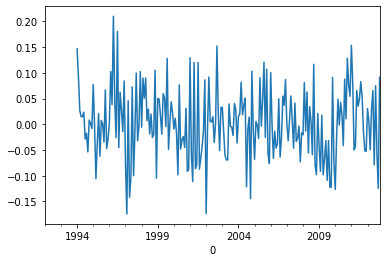

In [23]:
# давайте тогда попробуем еще раз
ts_log.diff(12).diff(12).plot()

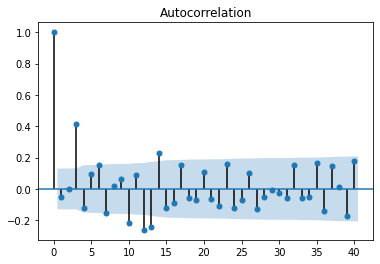

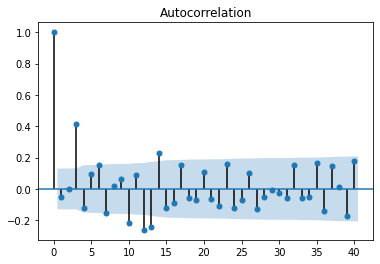

In [24]:
plot_acf(ts_log.diff(12).diff(12).dropna(), lags=40)

In [25]:
adfuller(ts_log.diff(12).diff().dropna())[1]

2.9448496463561783e-10

In [26]:
# отлично, вердикт о стационарности подтвержден, (d, D) = (0, 2)

In [27]:
# теперь разберемся с параметрами q, Q, p, P.

In [28]:
ts_flat = ts_log.diff(12).diff(12).dropna()

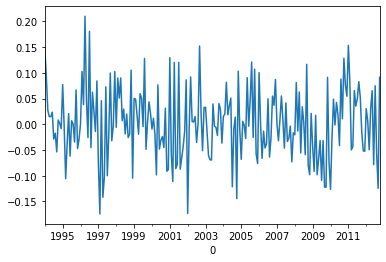

In [29]:
ts_flat.plot()

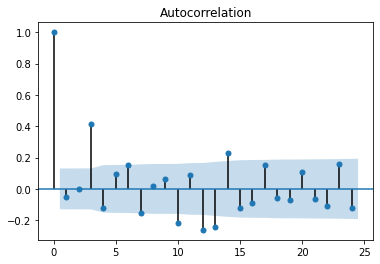

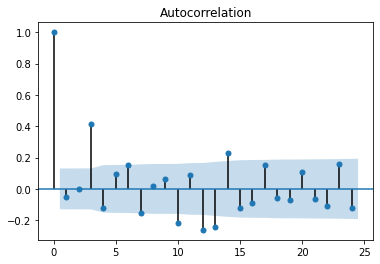

In [32]:
# отлично, для поиска параметров q, Q нарисуем график автокорреляций
# последний значимый несезонный лаг определяется как последний лаг, котоырй еще не пересек
# интервал значимости по модулю (то есть ВСЕ лаги от нулевого до него были выше порога значимости).
# В данном случае он равен одному (не забываем, что считаем мы с нуля - нулевого лага).
# Аналогично Q определятся как последний сезонный лаг, который не пересек порог значимости. В данном
# случае 0.
# Итак q = 0, Q = 1
plot_acf(ts_flat.dropna())

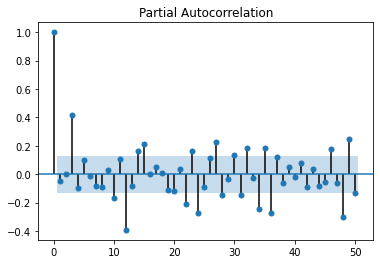

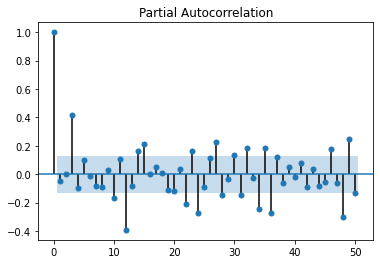

In [33]:
# теперь разберемся с параметрами p, P
# здесь видно, что последний значимый несезонный лаг равен 2
# а последний значимый сезонный лаг равен 0
# итак, p = 0, P = 3
plot_pacf(ts_flat, lags=50)

In [34]:
# теперь попробуем построить SARIMA с этими параметрами

In [35]:
from statsmodels.tsa.statespace import sarimax

In [36]:
pdq = (0, 0, 0)
PDQ = (3, 2, 1, 12)

In [37]:
model = sarimax.SARIMAX(ts_log, order=pdq, seasonal_order=PDQ)

/Users/gsinyakov/ts_course_summer/.env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/gsinyakov/ts_course_summer/.env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [38]:
res = model.fit()

In [39]:
preds = res.forecast(69)

In [40]:
plotting.plot_multiple_ts(ts_log, preds)

In [41]:
# восстановим в изначальном масштабе
plotting.plot_multiple_ts(np.exp(ts_log), np.exp(preds), ts_test)

In [42]:
# Видим что получилось весьма неплохо!

In [43]:
# чтобы убедиться еще раз, давайте проанализируем остатки

In [44]:
res = (np.exp(preds) - ts_test)

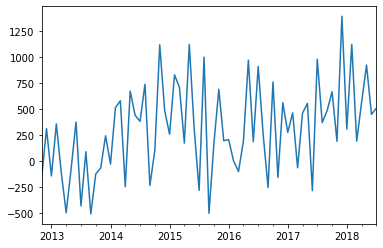

In [45]:
res.plot()

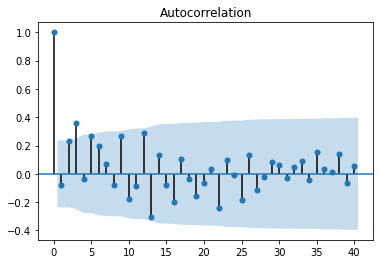

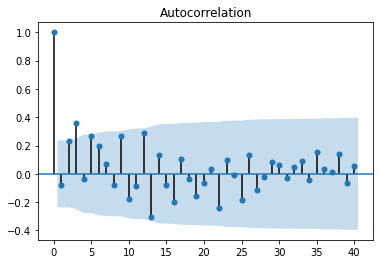

In [46]:
plot_acf(res, lags=40)

In [465]:
adfuller(res)[1]

0.14103969905057107